In [1]:
import matplotlib.pyplot as plt

# pylin: disable=C0103
import numpy as np
import pylops

plt.close('all')
np.random.seed(10)

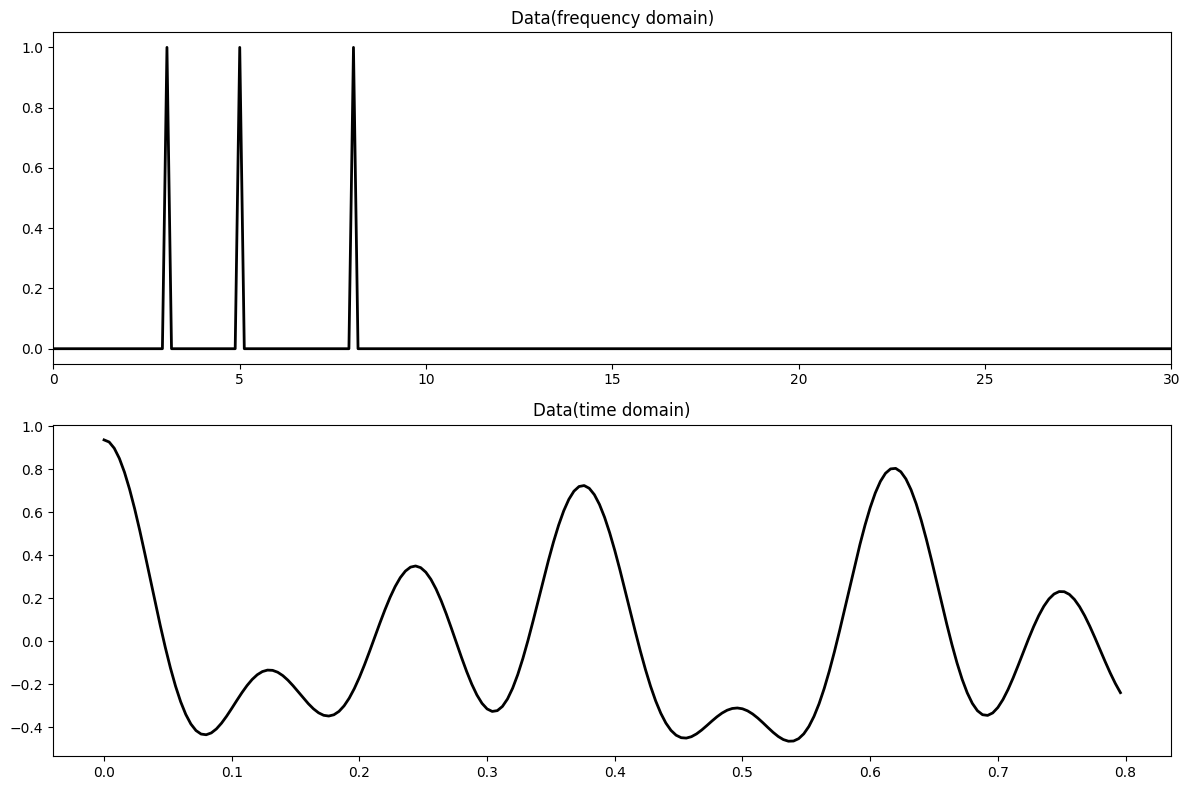

In [2]:
# Signal creation in frequency domain
ifreqs =[41, 25, 66]
amps = [1.0, 1.0, 1.0]
N = 200
nfft =2**11
dt = 0.004
t = np.arange(N) * dt
f = np.fft.rfftfreq(nfft, dt)

FFTop = 10 * pylops.signalprocessing.FFT(N, nfft=nfft, real=True)

X = np.zeros(nfft//2+1, dtype='complex128')
X[ifreqs] = amps
x = FFTop.H * X

fig, axs = plt.subplots(2, 1, figsize=(12, 8))
axs[0].plot(f, np.abs(X), "k", lw=2)
axs[0].set_xlim(0, 30)
axs[0].set_title("Data(frequency domain)")
axs[1].plot(t, x, "k", lw=2)
axs[1].set_title("Data(time domain)")
axs[1].axis("tight")
plt.tight_layout()

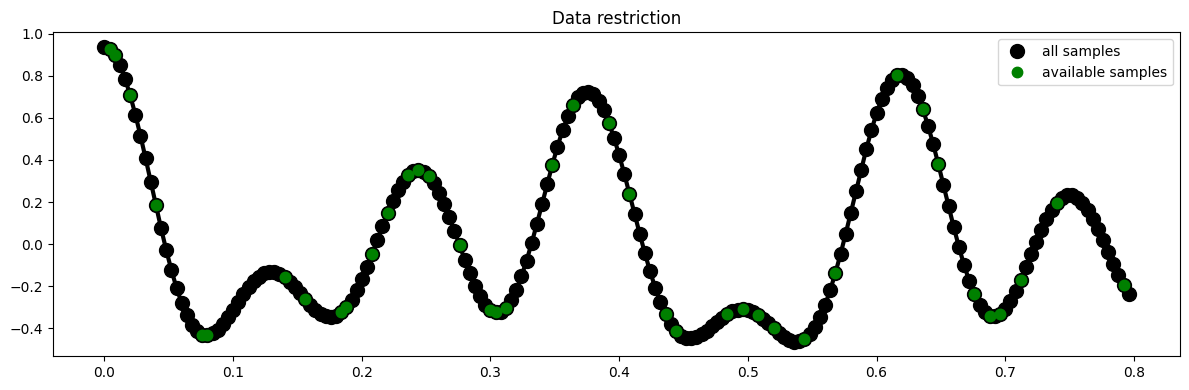

In [3]:
# subsampling locations
perc_subsampling = 0.2
Nsub = int(np.round(N * perc_subsampling))

iava = np.sort(np.random.permutation(np.arange(N))[:Nsub])

# create restriction operator (hm... this is something imporatnt to understand)
Rop = pylops.Restriction(N, iava, dtype='float64')

y = Rop * x
ymask = Rop.mask(x)

# Visualize data
fig = plt.figure(figsize=(12, 4))
plt.plot(t, x, "k", lw=3)
plt.plot(t, x, ".k", ms=20, label="all samples")
plt.plot(t, ymask, ".g", ms=15, label="available samples")
plt.legend()
plt.title("Data restriction")
plt.tight_layout()

To start, let's consider the simplest 'solver', i.e., *least-square inversion without regularization*. We aim here to minimize the following cost function:
$$ J = ||y - Rx||^{2}_{2} $$

Comments: Eu preciso entender esse operador R, que é o operador G no caso da inversão. Como que ele funciona

Depending on the choice of the operator $\textbf{R}$, such problem can be solved using explicit matrix solvers as well as iterative solvers. In this case we will be using the latter approach (more specifically the scipy implementation of the LSQR solver - i.e., [`scipy.sparse.linalg.lsqr`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.lsqr.html#scipy.sparse.linalg.lsqr)) as we do not want to explicitly create and invert a matrix. In most cases this will be the only viable approach as most of the large-scale optimization problems that we are interested to solve using PyLops do not lend naturally to the creation and inversion of explicit matrices

This first solver can be very easily implemented using the `/` for PyLops operators, which will automatically call the [`scipy.sparse.linalg.lsqr`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.lsqr.html#scipy.sparse.linalg.lsqr) with some default parameters.

In [4]:
xinv = Rop / y

We can also use [`pylops.optimization.leastsquares.regularized_inversion`](https://pylops.readthedocs.io/en/stable/api/generated/pylops.optimization.leastsquares.regularized_inversion.html#pylops.optimization.leastsquares.regularized_inversion) (without regularization term for now) and customize our solvers using `kwargs`

In [5]:
xinv = pylops.optimization.leastsquares.regularized_inversion(
    Rop,
    y,
    [],
    **dict(damp=0, iter_lim=10, show=True)
)[0]

RegularizedInversion
-----------------------------------------------------------------
The Operator Op has 40 rows and 200 cols
Regs=[]
epsRs=[]
-----------------------------------------------------------------
 
LSQR            Least-squares solution of  Ax = b
The matrix A has 40 rows and 200 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =       10
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   2.658e+00  2.658e+00    1.0e+00  3.8e-01
     1  0.00000e+00   0.000e+00  0.000e+00    0.0e+00  0.0e+00   0.0e+00  0.0e+00
 
LSQR finished
Ax - b is small enough, given atol, btol                  
 
istop =       1   r1norm = 0.0e+00   anorm = 0.0e+00   arnorm = 0.0e+00
itn   =       1   r2norm = 0.0e+00   acond = 0.0e+00   xnorm  = 2.7e+00
 


Finally we can select a different starting guess from the null vector

In [7]:
xinv_fromx0 = pylops.optimization.leastsquares.regularized_inversion(
    Rop,
    y,
    [],
    x0=np.ones(N),
    **dict(damp=0, iter_lim=10, show=True)
)[0]

RegularizedInversion
-----------------------------------------------------------------
The Operator Op has 40 rows and 200 cols
Regs=[]
epsRs=[]
-----------------------------------------------------------------
 
LSQR            Least-squares solution of  Ax = b
The matrix A has 40 rows and 200 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =       10
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   6.737e+00  6.737e+00    1.0e+00  1.5e-01
     1  0.00000e+00   0.000e+00  0.000e+00    0.0e+00  0.0e+00   0.0e+00  0.0e+00
 
LSQR finished
Ax - b is small enough, given atol, btol                  
 
istop =       1   r1norm = 0.0e+00   anorm = 0.0e+00   arnorm = 0.0e+00
itn   =       1   r2norm = 0.0e+00   acond = 0.0e+00   xnorm  = 6.7e+00
 


The cost function above can be also expanded in terms of its normal equations
$$ x_{ne} = (\textbf{R}^{T}\textbf{R})^{-1}\textbf{R}^{T}y $$

The method [`pylops.optimization.leastsquares.normal_equations_inversion`](https://pylops.readthedocs.io/en/stable/api/generated/pylops.optimization.leastsquares.normal_equations_inversion.html#pylops.optimization.leastsquares.normal_equations_inversion) implements such system of equations explicitly and solves them using an iterative scheme suitable for square matrices (i.e., $M = N$)

While this approach may seem not very useful, we will soon see how regularization terms could be easily added to the normal equations using this method

In [8]:
xne = pylops.optimization.leastsquares.normal_equations_inversion(
    Rop,
    y,
    [])[0]

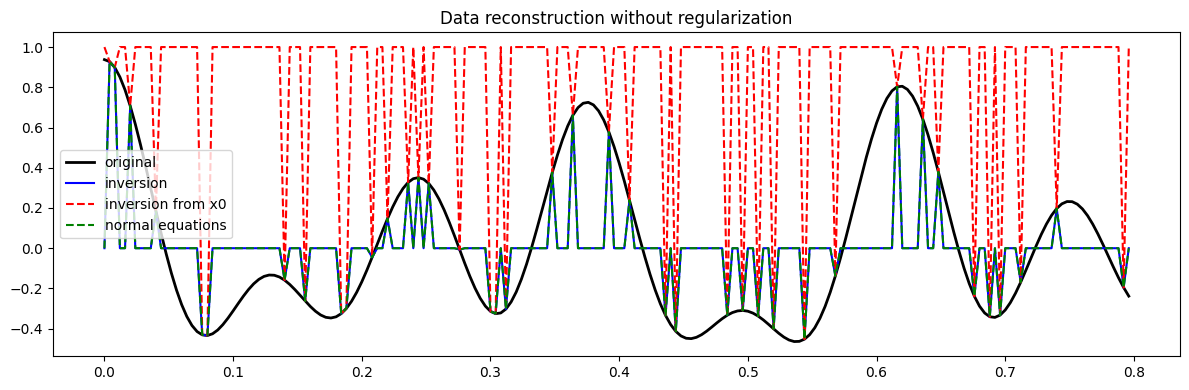

In [9]:
fig = plt.figure(figsize=(12, 4))
plt.plot(t, x, "k", lw=2, label="original")
plt.plot(t, xinv, "b", ms=10, label="inversion")
plt.plot(t, xinv_fromx0, "--r", ms=10, label="inversion from x0")
plt.plot(t, xne, "--g", ms=10, label="normal equations")
plt.legend()
plt.title("Data reconstruction without regularization")
plt.tight_layout()

# Regularization

You may have noticed that none of the inversion has been successfull in recovering the original signal. This is a clear indication that the problem we are trying to solve is highly ill-posed and requires some prior knowledge from the user.

We will now see how to add prior information to the inverse process in the form of regularization (or preconditioning). This can be done in two different ways
* regularization via [`pylops.optimization.leastsquares.normal_equations_inversion`](https://pylops.readthedocs.io/en/stable/api/generated/pylops.optimization.leastsquares.normal_equations_inversion.html#pylops.optimization.leastsquares.normal_equations_inversion) or [`pylops.optimization.leastsquares.regularized_inversion`](https://pylops.readthedocs.io/en/stable/api/generated/pylops.optimization.leastsquares.regularized_inversion.html#pylops.optimization.leastsquares.regularized_inversion)

* preconditioning via [`pylops.optimization.leastsquares.preconditioned_inversion`](https://pylops.readthedocs.io/en/stable/api/generated/pylops.optimization.leastsquares.preconditioned_inversion.html#pylops.optimization.leastsquares.preconditioned_inversion)

Let’s start by regularizing the normal equations using a second derivative operator
$$ x = (\textbf{R}^{T}\textbf{R} + \epsilon^{2}_{\nabla} \nabla^{T}\nabla)^{-1}\textbf{R}^{T}y $$

In [10]:
# Create regularization operator
D2op = pylops.SecondDerivative(N, dtype='float64')

# Regularized inversion
epsR = np.sqrt(0.1)
epsI = np.sqrt(1e-4)

xne = pylops.optimization.leastsquares.normal_equations_inversion(
    Rop,
    y,
    [D2op],
    epsI=epsI,
    epsRs=[epsR],
    **dict(maxiter=50)
)[0]

Note that in case we have access to a fast implementation for the chain of forward and adjoint for the regularization operator (i.e., $\nabla^{T}\nabla$), we can modify our call as follows:

In [13]:
ND2op = pylops.MatrixMult((D2op.H * D2op).tosparse())  # mimic fast D^T D

xne1 = pylops.optimization.leastsquares.normal_equations_inversion(
    Rop,
    y,
    [],
    NRegs=[ND2op],
    epsI=epsI,
    epsNRs=[epsR],
    **dict(maxiter=50)
)[0]

We can do the same while using `pylops.optimization.leastsquares.regularized_inversion` which solves the following augmented problem

$$ \begin{split}\begin{bmatrix}
    \mathbf{R}    \\
    \epsilon_\nabla \nabla
\end{bmatrix} \mathbf{x} =
    \begin{bmatrix}
    \mathbf{y}    \\
    0
\end{bmatrix}\end{split} $$

In [14]:
xreg = pylops.optimization.leastsquares.regularized_inversion(
    Rop,
    y,
    [D2op],
    epsRs=[np.sqrt(0.1)],
    **dict(damp=np.sqrt(1e-4), iter_lim=50, show=0)
)[0]

We can also write a preconditioned problem, whose cost function is
$$ J= \|\mathbf{y} - \mathbf{R} \mathbf{P} \mathbf{p}\|_2^2 $$

Where $\mathbf{P}$ is the preconditioned operator, $p$ is the projected model in the preconditioned space, and $ x = Pp $ is the model in the original model space we want to solve for. Note that a preconditioned problem converges much faster to its solution than its corresponding regularized problem. This can be done using the routine [`pylops.optimization.leastsquares.preconditioned_inversion`](https://pylops.readthedocs.io/en/stable/api/generated/pylops.optimization.leastsquares.preconditioned_inversion.html#pylops.optimization.leastsquares.preconditioned_inversion).

In [16]:
# Create regularization operator
Sop = pylops.Smoothing1D(nsmooth=11, dims=[N], dtype="float64")

# Invert for interpolated signal
xprec =pylops.optimization.leastsquares.preconditioned_inversion(
    Rop,
    y,
    Sop,
    **dict(damp=np.sqrt(1e-9), iter_lim=20, show=0)
)[0]

Let's finally visualize these solutions

C:\Users\Icarl\AppData\Local\Temp\ipykernel_25796\4023142675.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


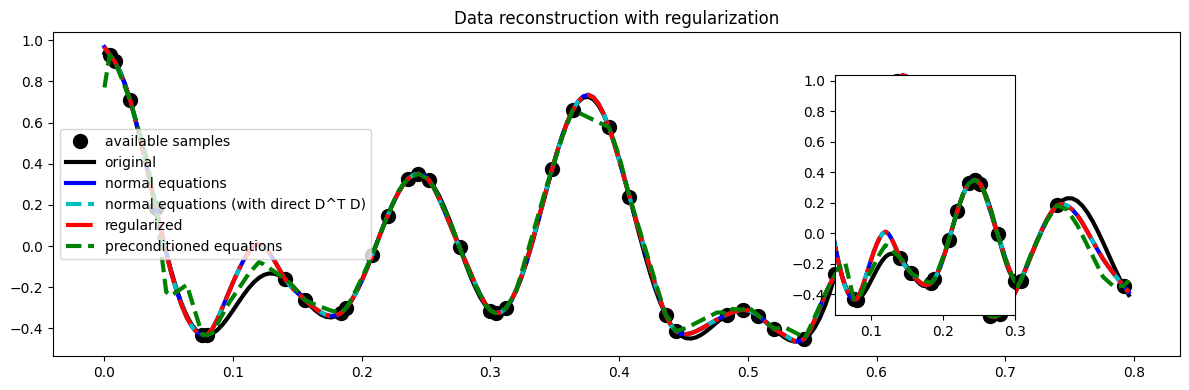

In [17]:
# sphinx_gallery_thumbnail_number=4
fig = plt.figure(figsize=(12, 4))
plt.plot(t[iava], y, ".k", ms=20, label="available samples")
plt.plot(t, x, "k", lw=3, label="original")
plt.plot(t, xne, "b", lw=3, label="normal equations")
plt.plot(t, xne1, "--c", lw=3, label="normal equations (with direct D^T D)")
plt.plot(t, xreg, "-.r", lw=3, label="regularized")
plt.plot(t, xprec, "--g", lw=3, label="preconditioned equations")
plt.legend()
plt.title("Data reconstruction with regularization")

subax = fig.add_axes([0.7, 0.2, 0.15, 0.6])
subax.plot(t[iava], y, ".k", ms=20)
subax.plot(t, x, "k", lw=3)
subax.plot(t, xne, "b", lw=3)
subax.plot(t, xne1, "--c", lw=3)
subax.plot(t, xreg, "-.r", lw=3)
subax.plot(t, xprec, "--g", lw=3)
subax.set_xlim(0.05, 0.3)
plt.tight_layout()

We have however so far only considered solvers that can include additional norm-2 regularization terms. A very active area of research is that of sparsity-promoting solvers (also sometimes referred to as compressive sensing): the regularization term added to the cost function to minimize has norm-p ($p \le 1$) and the problem is generally recasted by considering the model to be sparse in some domain. We can follow this philosophy as our signal to invert was actually created as superposition of 3 sinusoids (i.e., three spikes in the Fourier domain). Our new cost function is:
$$ J_{1} = ||y - \textbf{R}\textbf{F}p||^{2}_{2} + \epsilon || p ||_1 $$

Where $ \textbf{F} $ is the FFT operator. We will thus use the [`pylops.optimization.sparsity.ista`](https://pylops.readthedocs.io/en/stable/api/generated/pylops.optimization.sparsity.ista.html#pylops.optimization.sparsity.ista) and [`pylops.optimization.sparsity.fista`](https://pylops.readthedocs.io/en/stable/api/generated/pylops.optimization.sparsity.fista.html#pylops.optimization.sparsity.fista) solvers to estimate our input signal.

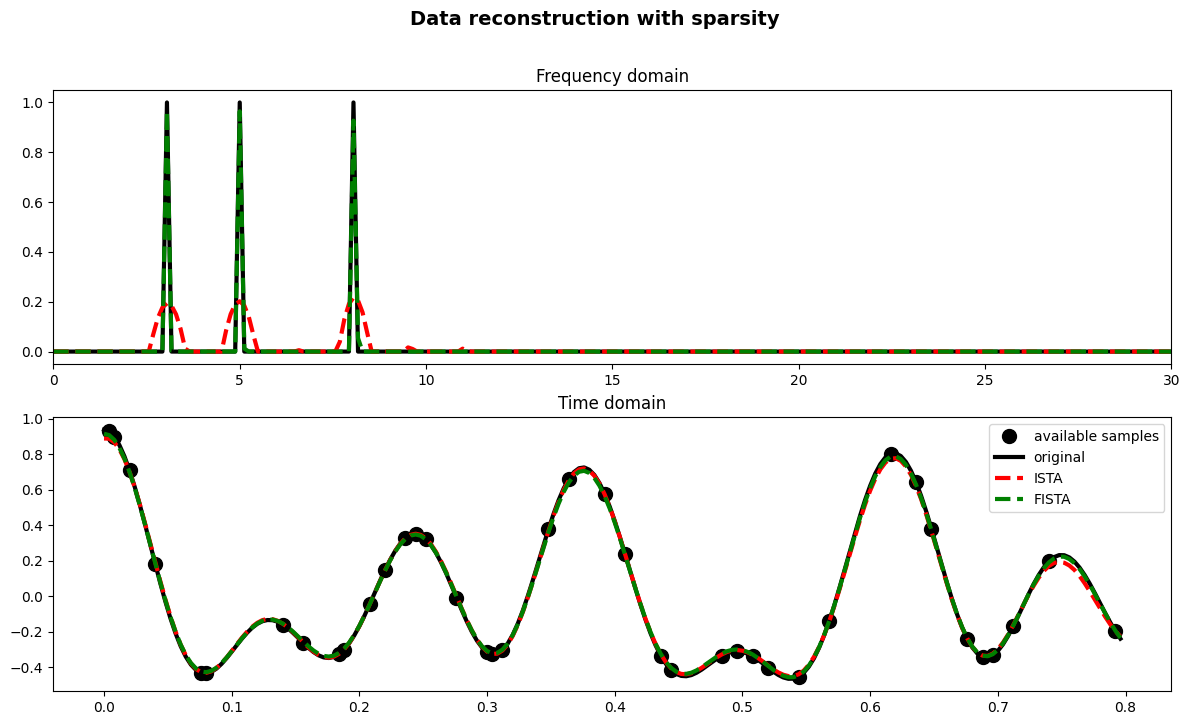

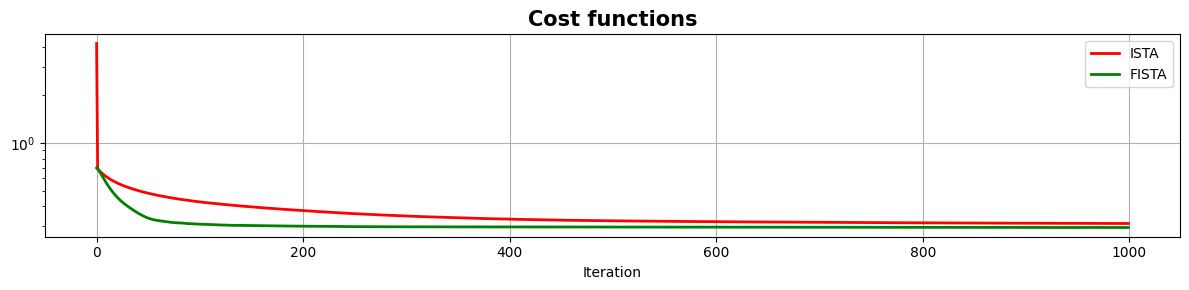

In [18]:
pista, niteri, costi = pylops.optimization.sparsity.ista(
    Rop * FFTop.H,
    y,
    niter=1000,
    eps=0.1,
    tol=1e-7,
)
xista = FFTop.H * pista

pfista, niterf, costf = pylops.optimization.sparsity.fista(
    Rop * FFTop.H,
    y,
    niter=1000,
    eps=0.1,
    tol=1e-7,
)
xfista = FFTop.H * pfista

fig, axs = plt.subplots(2, 1, figsize=(12, 8))
fig.suptitle("Data reconstruction with sparsity", fontsize=14, fontweight="bold", y=0.9)
axs[0].plot(f, np.abs(X), "k", lw=3)
axs[0].plot(f, np.abs(pista), "--r", lw=3)
axs[0].plot(f, np.abs(pfista), "--g", lw=3)
axs[0].set_xlim(0, 30)
axs[0].set_title("Frequency domain")
axs[1].plot(t[iava], y, ".k", ms=20, label="available samples")
axs[1].plot(t, x, "k", lw=3, label="original")
axs[1].plot(t, xista, "--r", lw=3, label="ISTA")
axs[1].plot(t, xfista, "--g", lw=3, label="FISTA")
axs[1].set_title("Time domain")
axs[1].axis("tight")
axs[1].legend()
plt.tight_layout()
plt.subplots_adjust(top=0.8)

fig, ax = plt.subplots(1, 1, figsize=(12, 3))
ax.semilogy(costi, "r", lw=2, label="ISTA")
ax.semilogy(costf, "g", lw=2, label="FISTA")
ax.set_title("Cost functions", size=15, fontweight="bold")
ax.set_xlabel("Iteration")
ax.legend()
ax.grid(True)
plt.tight_layout()

As you can see, changing parametrization of the model and imposing sparsity in the Fourier domain has given an extra improvement to our ability of recovering the underlying densely sampled input signal. Moreover, FISTA converges much faster than ISTA as expected and should be preferred when using sparse solvers.

Finally we consider a slightly different cost function (note that in this case we try to solve a constrained problem):

$$J_1 = \|\mathbf{p}\|_1
      \quad \text{subject to} \quad  \|\mathbf{y} -
      \mathbf{R} \mathbf{F} \mathbf{p}\|$$

A very popular solver to solve such kind of cost function is called spgl1 and can be accessed via [`pylops.optimization.sparsity.spgl1`](https://pylops.readthedocs.io/en/stable/api/generated/pylops.optimization.sparsity.spgl1.html#pylops.optimization.sparsity.spgl1)

pip install spgl1

In [20]:
#pip install spgl1

Note: you may need to restart the kernel to use updated packages.


In [ ]:
xspgl1, pspgl1, info = pylops.optimization.sparsity.spgl1(
    Rop, y, SOp=FFTop, tau=3, iter_lim=200
)

fig, axs = plt.subplots(2, 1, figsize=(12, 8))
fig.suptitle("Data reconstruction with SPGL1", fontsize=14, fontweight="bold", y=0.9)
axs[0].plot(f, np.abs(X), "k", lw=3)
axs[0].plot(f, np.abs(pspgl1), "--m", lw=3)
axs[0].set_xlim(0, 30)
axs[0].set_title("Frequency domain")
axs[1].plot(t[iava], y, ".k", ms=20, label="available samples")
axs[1].plot(t, x, "k", lw=3, label="original")
axs[1].plot(t, xspgl1, "--m", lw=3, label="SPGL1")
axs[1].set_title("Time domain")
axs[1].axis("tight")
axs[1].legend()
plt.tight_layout()
plt.subplots_adjust(top=0.8)

fig, ax = plt.subplots(1, 1, figsize=(12, 3))
ax.semilogy(info["rnorm2"], "k", lw=2, label="ISTA")
ax.set_title("Cost functions", size=15, fontweight="bold")
ax.set_xlabel("Iteration")
ax.legend()
ax.grid(True)
plt.tight_layout()